In [1]:
#!pip install ydata-profiling demoji nltk scikit-learn gensim  textblob spacy textstat transformers torch seaborn

In [2]:
import requests, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# classification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, AdamW
from transformers import AutoModel,AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

from torch.nn.utils.rnn import pad_sequence
import gc

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
df= pd.read_csv('conversation_dataset.csv')
df.head(2)

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic
0,first participant in conversation is deceiving...,"A: Hey, I have something really important to t...",437,1.0,0.0,NaN,NaN
1,second participant in conversation is deceivin...,"A: Hey Sarah, I heard you recently went on a t...",368,0.0,1.0,NaN,NaN


In [4]:
def add_sep_token(conversation):
    token = '[SEP]' # the seperator token for BERT
    # split the conversation into turns using line breaks as delimiters
    turns = conversation.split('\n\n')
    turns_with_sep = [turn + token for turn in turns]
    return '[CLS]' + ''.join(turns_with_sep)
 
df['conversation'] = df['conversation'].apply(add_sep_token)

In [5]:
df.loc[0]['conversation']

"[CLS]A: Hey, I have something really important to tell you.[SEP]B: Sure, what's up?[SEP]A: You know that job opportunity I told you about last month? Well, I got it![SEP]B: Wow, that's amazing news! Congratulations![SEP]A: Thank you! I knew you'd be happy for me. B:ut here's the thing, the company wants me to relocate to another city for this position.[SEP]B: Oh, really? That's a big change. Are you considering it?[SEP]A: Well, I've been thinking about it, but I'm not entirely sure yet. There are a few things to consider, like the cost of living and leaving my family behind.[SEP]B: Of course, those are valid concerns. B:ut if it's a great opportunity, maybe it's worth taking the risk?[SEP]A: That's true, but I've been doing some research, and it seems like the company has a lot of internal issues. I'm starting to doubt if it's the right move for me.[SEP]B: Oh, really? That's concerning. What kind of issues are you talking about?[SEP]A: Well, I've heard rumors that they have financial 

In [6]:
df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic
0,first participant in conversation is deceiving...,"[CLS]A: Hey, I have something really important...",437,1.0,0.0,NaN,NaN
1,second participant in conversation is deceivin...,"[CLS]A: Hey Sarah, I heard you recently went o...",368,0.0,1.0,NaN,NaN
2,both participants in conversation are deceivin...,"[CLS]A: Hey, how have you been? It's been a wh...",400,1.0,1.0,NaN,NaN
3,none of participants in conversation try to de...,[CLS]A: Hey Sarah! How was your weekend?[SEP]B...,494,0.0,0.0,NaN,NaN
4,first participant in conversation is deceiving...,[CLS]A: Hey there! How are you doing today?[SE...,534,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
183,none of participants in conversation try to de...,"[CLS]A: Good morning, I think we should begin ...",681,0.0,0.0,NaN,a diplomacy subject between european coutries
184,first participant in conversation is deceiving...,[CLS]A: Hey there! I saw your ad about looking...,476,1.0,0.0,NaN,sale or rental of property
185,second participant in conversation is deceivin...,[CLS]A: Hello! I saw your listing for the hous...,550,0.0,1.0,NaN,sale or rental of property
186,both participants in conversation are deceivin...,[CLS]A: Hello there! I saw your ad online abou...,544,1.0,1.0,NaN,sale or rental of property


---
### Preprocessing the combined dataset

In [7]:
#ProfileReport(df)

In [8]:
df[df['conversation'] == '']

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic


In [9]:
def text_preprocess(message):
    processed = []   
    for text in message:
        # replaace URLs
        text = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)",' <URL>',text)        
        # Remove HTML/XML tags (if any)
        text = re.sub(r'<.*?>', '', text)
        # Remove punctuation and symbols (not for now)
        # text = re.sub(r'[^\w\s]', '', text) 
        # Remove numbers - not in this dataset!
        #text = re.sub(r'\d+', '', text)
        # Remove whitespaces (including new lines and tabs)
        text = text.strip().replace("\n", " ").replace("\r", " ").replace("\t", " ")
        
        processed.append(text)       
    return processed

In [10]:
df['conversation'] = text_preprocess(list(df['conversation']))
df

,category,conversation,word_count,A_bad_intent,B_bad_intent,description,topic
0,first participant in conversation is deceiving...,"[CLS]A: Hey, I have something really important...",437,1.0,0.0,NaN,NaN
1,second participant in conversation is deceivin...,"[CLS]A: Hey Sarah, I heard you recently went o...",368,0.0,1.0,NaN,NaN
2,both participants in conversation are deceivin...,"[CLS]A: Hey, how have you been? It's been a wh...",400,1.0,1.0,NaN,NaN
3,none of participants in conversation try to de...,[CLS]A: Hey Sarah! How was your weekend?[SEP]B...,494,0.0,0.0,NaN,NaN
4,first participant in conversation is deceiving...,[CLS]A: Hey there! How are you doing today?[SE...,534,1.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...
183,none of participants in conversation try to de...,"[CLS]A: Good morning, I think we should begin ...",681,0.0,0.0,NaN,a diplomacy subject between european coutries
184,first participant in conversation is deceiving...,[CLS]A: Hey there! I saw your ad about looking...,476,1.0,0.0,NaN,sale or rental of property
185,second participant in conversation is deceivin...,[CLS]A: Hello! I saw your listing for the hous...,550,0.0,1.0,NaN,sale or rental of property
186,both participants in conversation are deceivin...,[CLS]A: Hello there! I saw your ad online abou...,544,1.0,1.0,NaN,sale or rental of property


In [11]:
# number of conversation wth more than 512 words
long_conversations = sum([1 if len(i.split()) > 512 else 0 for i in df['conversation']])
long_conversations

111

In [12]:
df['conversation'].str.split().apply(lambda x : len(x)).describe()

count     188.000000
mean      552.914894
std       140.061305
min       272.000000
25%       462.750000
50%       538.000000
75%       622.250000
max      1428.000000
Name: conversation, dtype: float64

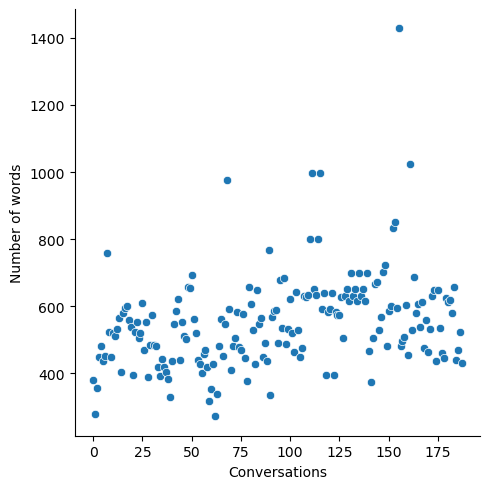

In [13]:
lensofc = [len(i.split()) for i in df['conversation']]
long_c_plot = sns.relplot(lensofc)
long_c_plot.set_ylabels("Number of words", clear_inner=False)
long_c_plot.set_xlabels("Conversations", clear_inner=False)

In [14]:
#df['conversation'].loc[0]

In [15]:
# find conversations with more than 5000 words
longs = [df.index[df['conversation'] == i].tolist()[0] for i in df['conversation'] if len(i.split()) > 500]

In [16]:
longs

[7,
 8,
 10,
 11,
 12,
 13,
 15,
 16,
 17,
 18,
 19,
 21,
 22,
 23,
 24,
 25,
 27,
 30,
 41,
 42,
 43,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 65,
 67,
 68,
 69,
 72,
 73,
 76,
 79,
 80,
 81,
 83,
 84,
 85,
 89,
 91,
 92,
 93,
 95,
 96,
 97,
 99,
 100,
 101,
 103,
 104,
 107,
 108,
 109,
 110,
 111,
 112,
 109,
 110,
 111,
 116,
 117,
 119,
 116,
 117,
 119,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 128,
 129,
 130,
 131,
 128,
 129,
 130,
 131,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 150,
 151,
 152,
 153,
 154,
 155,
 158,
 159,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 169,
 171,
 172,
 173,
 175,
 176,
 179,
 180,
 181,
 182,
 183,
 186]

In [17]:
len(longs)

119

In [18]:
#lets drop long conversations
#df.drop(longs, axis=0, inplace=True)

---
### Preaper dataset for classification

<Axes: xlabel='A_bad_intent', ylabel='count'>

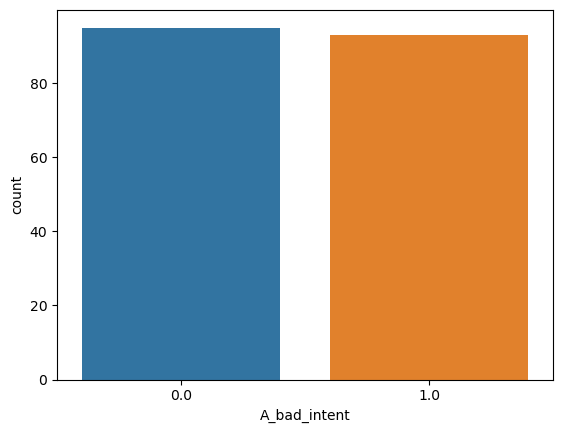

In [19]:
sns.countplot(data = df, x= df['A_bad_intent'])

<Axes: xlabel='B_bad_intent', ylabel='count'>

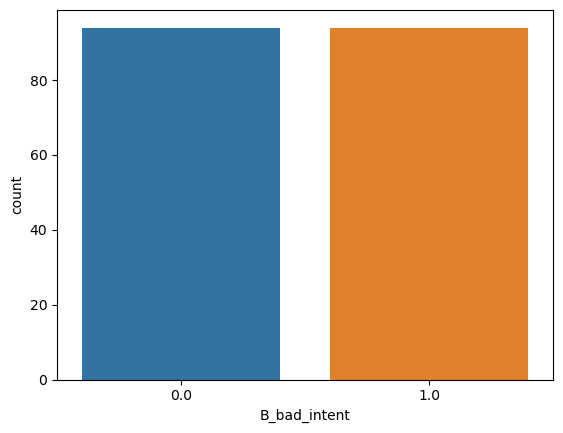

In [20]:
sns.countplot(data = df, x= df['B_bad_intent'])

#### balance the dataset or evalue the classification by weighted F1 score???

+ Normalization /scaling --> no need when using BERT
+ Shuffling --> shuffle=True in train_test_split


---
### Classification

hyperparamethers from Appendix A.3 of the https://arxiv.org/pdf/1810.04805.pdf

+ Batch size: 16, 32 (here to make code run on low memory batch size is smaller)
+ Learning rate (Adam): 5e-5, 3e-5, 2e-5
+ Number of epochs: 2, 3, 4

In [21]:
#@todo check oov words

In [22]:
#@todo improve metrics calculation -- check overfitting

In [23]:
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=128'

In [44]:
# If there's a GPU available...
if torch.cuda.is_available():      
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

There are 1 GPU(s) available.
GPU: NVIDIA A100 80GB PCIe MIG 2g.20gb


---
#### Automodel


In [25]:
class ConversationsDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer,  int_labels):
        self.data = data       
        self.int_labels = int_labels
        self.tokenizer = tokenizer
               
    def __getitem__(self, idx):
        text = self.data[idx]['conversation']

        # Use tokenizer.encode_plus
        encodings = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512,  # You might need to adjust this based on your model
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )

        # Create the item dictionary
        item = {key: val.squeeze() for key, val in encodings.items()}  # Squeeze to remove batch dimension
        item['labels'] = torch.tensor(self.int_labels[idx])
 
        return item
 
    def __len__(self):
        return len(self.int_labels)

In [26]:
#bert-base-uncased model has only lowercase letters!
#bert-base-cased: This model is case-sensitive
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 

#Train Test Validation split

# shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
 
# define split sizes
train_size = int(0.7 * len(df)) 
val_size = int(0.15 * len(df))
 
# split the DataFrame
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

In [27]:
train_data = train_df.to_dict('records')
val_data = val_df.to_dict('records')
test_data = test_df.to_dict('records')


train_labels = train_df['category'].tolist()
train_label_to_idx = {label: idx for idx, label in enumerate(sorted(set(train_labels)))}
# convert labels to integers
train_int_labels = [train_label_to_idx[label] for label in train_labels]


val_labels = val_df['category'].tolist()
val_label_to_idx = {label: idx for idx, label in enumerate(sorted(set(val_labels)))}
# convert labels to integers
val_int_labels = [val_label_to_idx[label] for label in val_labels]

In [28]:
# batch and suffle the data
train_dataset = ConversationsDataset(train_data, tokenizer, train_int_labels )
val_dataset = ConversationsDataset(val_data, tokenizer,  val_int_labels)
test_dataset = ConversationsDataset(test_data, tokenizer,  train_df['category'].tolist())

In [52]:
df['category'].nunique()

4

In [54]:
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name 
                                                           ,num_labels=df['category'].nunique() 
                                                           #,problem_type="multi_class_classification"
                                                           #,id2label=id2label
                                                           #,label2id=label2id
                                                          )
#tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`
#pip install accelerate -U

In [60]:
training_args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    #push_to_hub=True,
)

In [56]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

In [57]:
model = model.to(device)

In [35]:
#gives a readable summary of memory allocation and allows to figure the reason of CUDA running out of memory
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [61]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [62]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.393161,0.214286
2,No log,1.395053,0.214286
3,No log,1.416646,0.214286
4,No log,1.385315,0.214286
5,No log,1.412371,0.214286


TrainOutput(global_step=165, training_loss=1.385902266068892, metrics={'train_runtime': 125.9584, 'train_samples_per_second': 5.2, 'train_steps_per_second': 1.31, 'total_flos': 172340835962880.0, 'train_loss': 1.385902266068892, 'epoch': 5.0})

In [63]:
trainer.evaluate()

{'eval_loss': 1.3931611776351929,
 'eval_accuracy': 0.21428571428571427,
 'eval_runtime': 1.0281,
 'eval_samples_per_second': 27.235,
 'eval_steps_per_second': 6.809,
 'epoch': 5.0}

In [69]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    2530 MB |    5858 MB |    2529 GB |    2526 GB |
|       from large pool |    2527 MB |    5857 MB |    2528 GB |    2526 GB |
|       from small pool |       2 MB |       3 MB |       0 GB |       0 GB |
|---------------------------------------------------------------------------|
| Active memory         |    2530 MB |    5858 MB |    2529 GB |    2526 GB |
|       from large pool |    2527 MB |    5857 MB |    2528 GB |